In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


/home/IBEO.AS/soe/UMLA/virtualenv/tensorflow_2_1/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


1 Physical GPUs, 1 Logical GPUs


In [6]:
img_height = 64
img_width = 64
batch_size = 12

In [7]:
train_generator = ImageDataGenerator(rescale=1. / 255,
                                     horizontal_flip=True,
                                     validation_split=0.1)

test_generator = ImageDataGenerator(rescale=1. / 255,
                                    validation_split=0.1)

ds_train = train_generator.flow_from_directory(directory='dataset/rock_paper_scissor_videobased/',
                                               color_mode="grayscale",
                                               batch_size=batch_size,
                                               shuffle=True,
                                               target_size=(img_height, img_width),
                                               seed=42,
                                               classes=["rock", "paper", "scissor"],
                                               subset="training")

ds_test = test_generator.flow_from_directory(directory='dataset/rock_paper_scissor_videobased/',
                                             color_mode="grayscale",
                                             batch_size=batch_size,
                                             shuffle=False,
                                             target_size=(img_height, img_width),
                                             seed=42,
                                             classes=["rock","paper", "scissor"],
                                             subset="validation")


Found 165 images belonging to 3 classes.
Found 16 images belonging to 3 classes.


(12, 64, 64, 1) (12, 3)


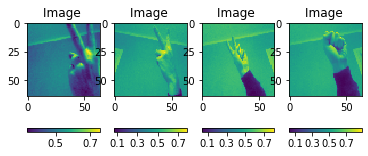

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

x,y = ds_train.next()
print(x.shape,y.shape)


fig = plt.figure()

for idx, image in enumerate(x[0:4]):
    ax = fig.add_subplot(1, 4, idx+1)
    imgplot = plt.imshow(image[:,:,0])
    ax.set_title(f'Image ')
    plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

In [10]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(64,64,1), padding="same", name="input_tensor"))
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3), padding="same", name="conv2"))
model.add(Activation("relu"))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation ="relu"))
model.add(Dense(3, activation="softmax", name = "output_tensor"))

opt = Adam(learning_rate=0.0001)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_tensor (Conv2D)        (None, 64, 64, 64)        640       
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 32)        18464     
_________________________________________________________________
activation_3 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [11]:

model.fit_generator(ds_train, steps_per_epoch=np.floor(ds_train.n/batch_size), epochs=16, validation_data=ds_test, validation_steps=np.floor(ds_test.n / batch_size))

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13.0 steps, validate for 1.0 steps
Epoch 1/16
13/13 [==============================] - 2s 180ms/step - loss: 1.1074 - accuracy: 0.3399 - val_loss: 1.0962 - val_accuracy: 0.4167
Epoch 2/16
13/13 [==============================] - 0s 34ms/step - loss: 1.0890 - accuracy: 0.4183 - val_loss: 1.1307 - val_accuracy: 0.1667
Epoch 3/16
13/13 [==============================] - 0s 35ms/step - loss: 1.0765 - accuracy: 0.4510 - val_loss: 1.0911 - val_accuracy: 0.4167
Epoch 4/16
13/13 [==============================] - 0s 33ms/step - loss: 1.0627 - accuracy: 0.5556 - val_loss: 1.1091 - val_accuracy: 0.1667
Epoch 5/16
13/13 [==============================] - 0s 32ms/step - loss: 1.0574 - accuracy: 0.5359 - val_loss: 1.0777 - val_accuracy: 0.5000
Epoch 6/16
13/13 [==============================] - 0s 33ms/step - loss: 1.0451 - accuracy: 0.4967 - val_loss: 1.0387 - val

In [15]:
labels = ["Rock", "Paper", "Scissor"]

In [16]:
cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    test_img_resized = cv2.resize(gray, (img_width, img_height), interpolation = cv2.INTER_AREA)

    test_img_resized = test_img_resized/255

    x_input = np.expand_dims(test_img_resized, axis=0)
    x_input = np.expand_dims(x_input, axis=-1)
    
    
    result_label = model.predict_classes(x_input)
    font = cv2.FONT_HERSHEY_SIMPLEX
    output = cv2.resize(test_img_resized, (img_width*4, img_height*4), interpolation = cv2.INTER_AREA)

    cv2.putText(output,labels[result_label[0]],(10,60), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    # Display the resulting frame
    cv2.imshow('frame',output)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()